# ANDI challenge 2022 datasets

Welcome to the guide for the ANDI Challenge 2022 datasets. In this notebook we will explore the new diffusion models considered for the challenge. As opposed to the diffusion models of the previous challenge (check the [paper](https://www.nature.com/articles/s41467-021-26320-w) and the [previous tutorial](https://github.com/AnDiChallenge/andi_datasets/blob/main/tutorials/challenge2020_datasets.ipynb) ), this time we focus on *phenomenological* models. That is, models in which diffusion properties arise from the interaction of the moving particle with the environment, or due to its inherent properties. Moreover, we will focus in models in which diffusive changes happened randomly, because of different reasons. Nonetheless, we are still in the ANDI Challenge, so *anomalous* is still here! All particles will diffuse following fractional Brownian motion, with different anomalous exponents $\alpha$. We have developed 5 types of diffusion, with which we want to cover most of the phenomena one encounters in real, physical, scenarios. Before reviewing them, let us set some initial conditions which will be considered in all models. This are also the parameters similar to the ones considered in the datasets generated for the challenge.

**Experimental diffusion conditions**
- Environment size ($L$): 

- Fielf of view (fov): $128 x 128 px^2$, with a pixel size of 100 nm, for a size of the box $L=12.8 \ \mu m$. We will simulate trajectories in a box of 1.5*fov and the only considers segments inside the fov. This allows to eliminate problems with boundaries.
- Frame rate $= 0.1 Hz$, i.e. $\Delta t = 100 \ ms  = 0.1 \ s$ .
- Typical $D = 0.01 \ \mu m^2/s$. To calculate the input of the program, we need to consider the following:
    - As a working definition of $D$, valid also for anomalous diffusion, we consider it as proporcional to the variance of the displacements along one dimension at the shortest time lag, i.e. $\sigma_{\Delta x}^2= 2  D \Delta t $
    - Given the values of pixel size and frame rate, in adimensional unit $D$ is given by: $D= 0.01 \ \frac{\mu m^2}{s} \ \frac{0.1 s/ \Delta t }{  0.01 \mu m^2/px^2} = 0.1 px^2/\Delta t $ .
    - Localization precision $\sigma_{x} = 12 \ nm = \frac{12 \ nm} {100 \ nm/px}  = 0.12 \ px$.


In [1]:
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_trajectories import segs_inside_fov
from andi_datasets.utils_metrics import label_filter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def TAMSD(traj, t_lags):
    tamsd = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags):        
        for p in range(len(traj)-t):
            tamsd[idx] += (traj[p]-traj[p+t])**2            
        tamsd[idx] /= len(traj)-t    
    return tamsd

def get_D(traj, t_lags):
    tasmd = TAMSD(traj, t_lags)
    return np.polyfit(t_lags, tasmd, deg = 1)[0]/2

def get_exponent(traj, t_lags):
    tasmd = TAMSD(traj, t_lags)
    return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]

In [65]:
def get_D(traj, t_lags):
    tasmd = TAMSD(traj, t_lags)
    return np.polyfit(t_lags, tasmd, deg = 1)[0]/2

D = 1
dim = 2 

Dfit = [];
for _ in range(10000):
    t = np.cumsum(np.sqrt(2*D)*np.random.randn(dim, 10), axis = 1)
    t = (np.sum(t**2, axis = 0))**(1/2)
    Dfit.append(get_D(t, [2,3,4]))
    
np.mean(Dfit)

1.062559067021555

In [43]:
t = np.cumsum(np.sqrt(2*D)*np.random.randn(2, 10), axis = 1)
np.sum(t**2, axis = 0).shape

(10,)

Text(0.5, 0, 'D')

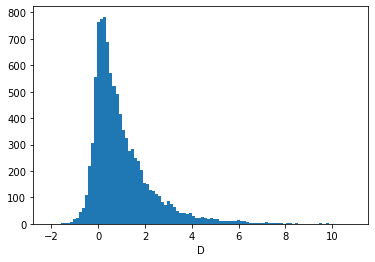

In [16]:
plt.hist(D, bins = 100);
plt.xlabel('D')

# Initial test dataset

We will create a data for 6 conditions. All will have the following 'experimental' conditions:

- Fielf of view (fov): $128 x 128 px^2$, with a pixel size of 100 nm, for a size of the box $L=12.8 \ \mu m$. We will simulate trajectories in a box of 1.5*fov and the only considers segments inside the fov. This allows to eliminate problems with boundaries.
- Frame rate $= 0.1 Hz$, i.e. $\Delta t = 100 \ ms  = 0.1 \ s$ .
- Typical $D = 0.01 \ \mu m^2/s$. To calculate the input of the program, we need to consider the following:
    - As a working definition of $D$, valid also for anomalous diffusion, we consider it as proporcional to the variance of the displacements along one dimension at the shortest time lag, i.e. $\sigma_{\Delta x}^2= 2  D \Delta t $
    - Given the values of pixel size and frame rate, in adimensional unit $D$ is given by: $D= 0.01 \ \frac{\mu m^2}{s} \ \frac{0.1 s/ \Delta t }{  0.01 \mu m^2/px^2} = 0.1 px^2/\Delta t $ .
    - Localization precision $\sigma_{x} = 12 \ nm = \frac{12 \ nm} {100 \ nm/px}  = 0.12 \ px$.

In [3]:
# Time units: frame; Space units: pixels 
# Lenght of trajectories:
# We simulate longer trajectories:
T = 500
# But then will consider any segment with minimum length inside the FOV
min_length = 20

# field of view and box size
fov = 128
L = 128*1.2
# we define now the fov w.r.t to L:
fov_min = int(128*0.2/2); fov_max =int(L - 128*0.2/2)

# This D will be consider the typical, and the others will be factors of this one.
D = 0.1 

# Localization precision
sigma_noise = 0.12 

# Finally, we consider 5000 simulated trajectories per dataset.
# The final number will vary depending of the segmentation with the FOV
N = 5000

### Condition 1 $\rightarrow$ 2 state diffusion 
Three state problem with properties:
- $\alpha = [0.5, 1.5]$
- $D_1 = [1, 0.1]\cdot D$
- $M = \begin{pmatrix} 0.98 & 0.02 \\   0.02 & 0.98 \end{pmatrix}$

In [4]:
N = 20

In [5]:
trajs, labels = models_phenom().multi_state(N = N,
                                            T = T,
                                            L = L,
                                            M = np.array([[0.98 , 0.02],[0.02 ,0.98]]),
                                            alphas = [0.5, 1.5],
                                            Ds = D*np.array([1, 0.1]))

# Adding small localization noise
trajs += np.random.randn(T, N, 2)*sigma_noise

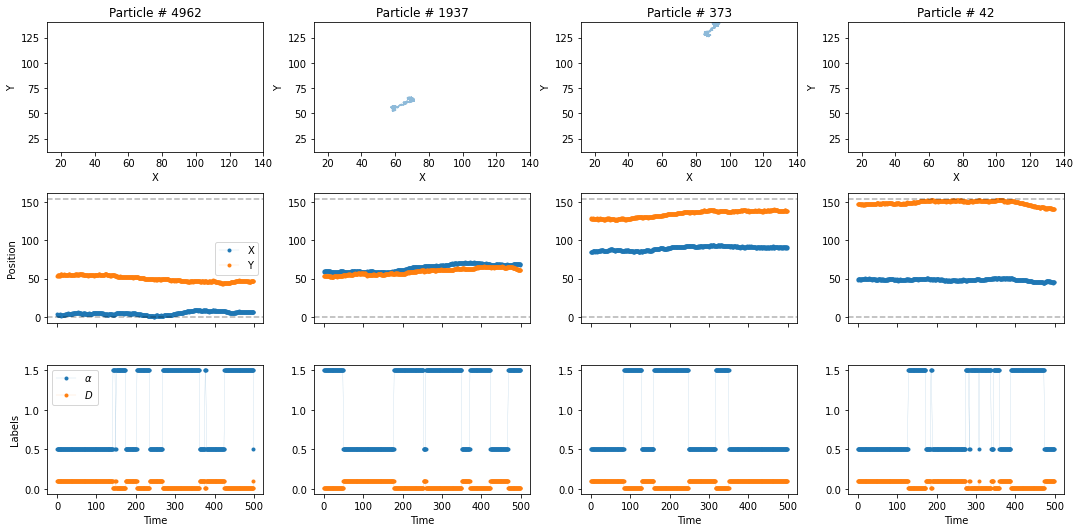

In [7]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for ax in axs.transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y', xlim = (fov_min, fov_max), ylim = (fov_min, fov_max))

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

**Apply field of view, smoothing labels and save in dataframe**

In [6]:
t_df = trajs.transpose((1, 0, 2)).copy()
labels_df = labels.transpose(1, 0, 2)

xs = []
ys = []
als = []
ds = []
idxs = []

idx_t = 0
for traj, l_alpha, l_D in zip(tqdm(t_df), labels_df[:, :, 0], labels_df[:, :, 1]):
    
    # Check FOV and 
    idx_inside_segments = segs_inside_fov(traj, fov_max, fov_min, min_length)
    
    if idx_inside_segments is not None:
        
        for idx_in in idx_inside_segments:            
            seg_x = traj[idx_in[0]:idx_in[1], 0]
            seg_y = traj[idx_in[0]:idx_in[1], 1]
            seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
            seg_D = l_D[idx_in[0]:idx_in[1]]
            
            # Filtering
            seg_alpha = label_filter(seg_alpha)
            seg_D = label_filter(seg_D)

            xs += seg_x.tolist()
            ys += seg_y.tolist()
            als += seg_alpha.tolist()
            ds += seg_D.tolist()
            idxs += (np.ones(len(seg_x))*idx_t).tolist()
            
            idx_t += 1
            
            
tr_to_df = np.vstack((idxs,
                      xs,
                      ys)).transpose()

labs_to_df = np.vstack((idxs,
                        als,
                        ds)).transpose()

df_in1 = pd.DataFrame(tr_to_df)
df_out1 = pd.DataFrame(labs_to_df)   
    
df_in1.columns = ['idx', 'x', 'y']
df_out1.columns = ['idx', 'alpha', 'D']

  0%|          | 0/20 [00:00<?, ?it/s]

c:\users\gorka\github\andi_datasets_dev\andi_datasets\utils_trajectories.py:247: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


In [9]:
df_in1

,idx,x,y
0,0.0,23.729957,74.828615
1,0.0,23.812932,74.787115
2,0.0,23.572713,75.498748
3,0.0,24.466709,74.934617
4,0.0,23.797551,75.188112
...,...,...,...
7753,17.0,104.075655,58.459681
7754,17.0,103.941464,57.808505
7755,17.0,102.807388,57.382420
7756,17.0,102.777803,57.774364


In [10]:
df_in1.to_csv('../exports/condition_1.csv', index = False)
df_out1.to_csv('../exports/labels_condition_1.csv', index = False)

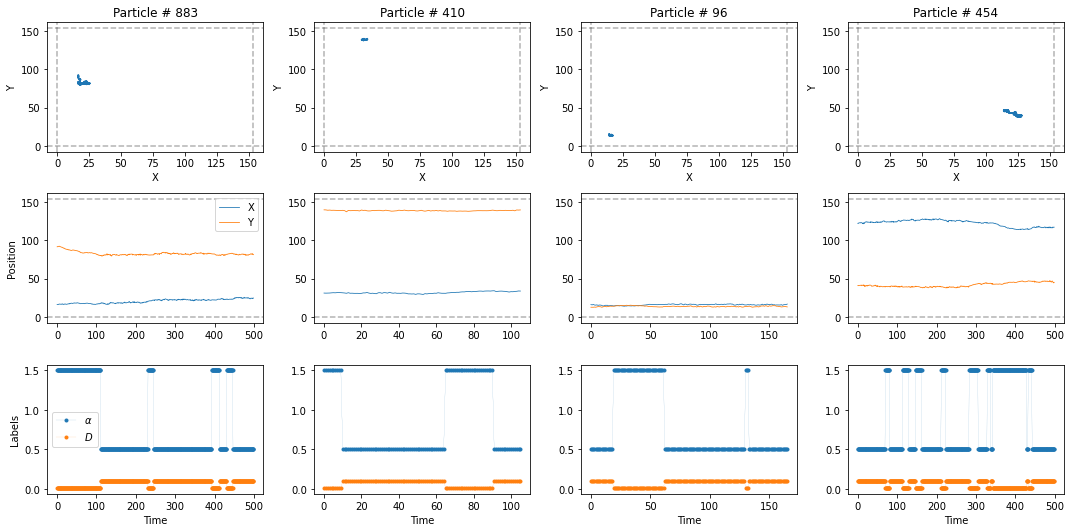

In [10]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

idx_trajs = np.random.randint(0, 1000, axs.shape[1])

for ax, idx in zip(axs.transpose(), idx_trajs):
    
    x = df_in1.loc[df_in1.idx == idx].x.values
    y = df_in1.loc[df_in1.idx == idx].y.values
    la = df_out1.loc[df_out1.idx == idx].alpha.values
    ld = df_out1.loc[df_out1.idx == idx].D.values
    
    part = np.random.randint(1000)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(x, y)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(x, '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(y, '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(la, 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(ld, 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
# plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

### Condition 2 $\rightarrow$ Single state

Here we have three populations, with same $D$ and three $\alpha = [0.5, 1, 1.5]$. We will have [1000,1000,1000] trajectories per population.

In [11]:
Ns = [1000,1000,1000]
alphas = [0.5,1,1.5]

    
trajs, labels = [], []
for ns, alpha in zip(Ns, alphas):
    ts, ls = models_phenom().single_state(N = ns,
                                        L = L,
                                        T = T, 
                                        alpha = alpha,
                                        D = D)
    trajs.append(ts)
    labels.append(ls)
    
trajs = np.concatenate(trajs, axis = 1)
labels = np.concatenate(labels, axis = 1)

# Adding small localization noise
trajs += np.random.randn(T, np.sum(Ns), 2)*sigma_noise

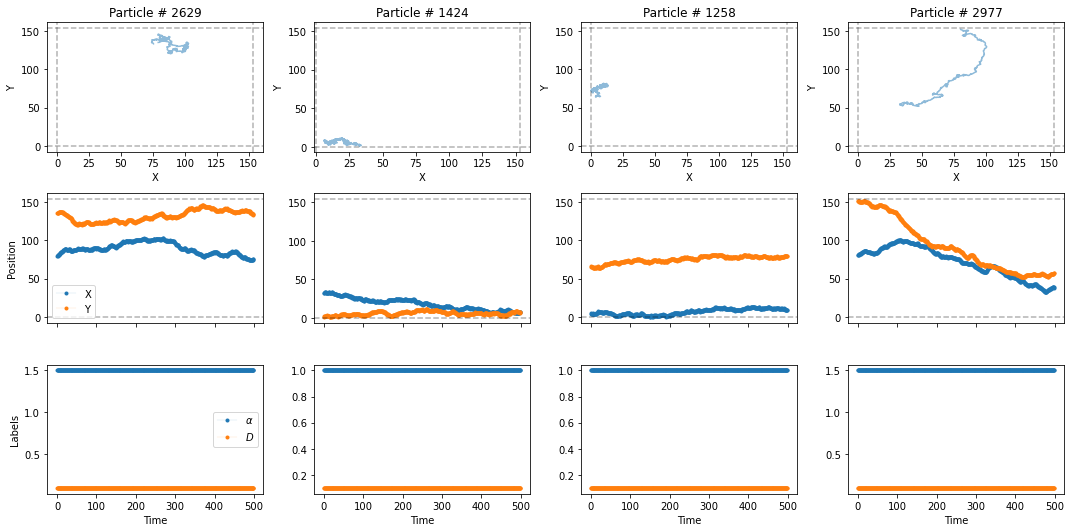

In [12]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for ax in axs.transpose():
    part = np.random.randint(np.sum(Ns))    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

**Apply field of view, smoothing labels and save in dataframe**

In [13]:
t_df = trajs.transpose((1, 0, 2)).copy()
labels_df = labels.transpose(1, 0, 2)

xs = []
ys = []
als = []
ds = []
idxs = []

df_in2 = pd.DataFrame()
df_out2 = pd.DataFrame()
idx_t = 0
for traj, l_alpha, l_D in zip(tqdm(t_df), labels_df[:, :, 0], labels_df[:, :, 1]):
    
    # Check FOV and 
    idx_inside_segments = segs_inside_fov(traj, fov_max, fov_min, min_length)
    
    if idx_inside_segments is not None:
        
        for idx_in in idx_inside_segments:            
            seg_x = traj[idx_in[0]:idx_in[1], 0]
            seg_y = traj[idx_in[0]:idx_in[1], 1]
            seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
            seg_D = l_D[idx_in[0]:idx_in[1]]
            
            # no need for filtering!
#             seg_alpha = label_filter(seg_alpha)
#             seg_D = label_filter(seg_D)

            xs += seg_x.tolist()
            ys += seg_y.tolist()
            als += seg_alpha.tolist()
            ds += seg_D.tolist()
            idxs += (np.ones(len(seg_x))*idx_t).tolist()
            
            idx_t += 1
            
            
tr_to_df = np.vstack((idxs,
                      xs,
                      ys)).transpose()

labs_to_df = np.vstack((idxs,
                        als,
                        ds)).transpose()

df_in2 = pd.DataFrame(tr_to_df)
df_out2 = pd.DataFrame(labs_to_df)   
    
df_in2.columns = ['idx', 'x', 'y']
df_out2.columns = ['idx', 'alpha', 'D']

  0%|          | 0/3000 [00:00<?, ?it/s]

d:\repos\andi_datasets_dev\andi_datasets\utils_trajectories.py:214: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


In [14]:
df_in2.to_csv('../exports/condition_2.csv', index = False)
df_out2.to_csv('../exports/labels_condition_2.csv', index = False)

### Condition 3 $\rightarrow$ Compartments
Two diffusive state with properties:
- $\alpha = 0.7$
- $D = [0.1, 1]$
- transmittance $T = 0.1$


(0.0, 153.6)

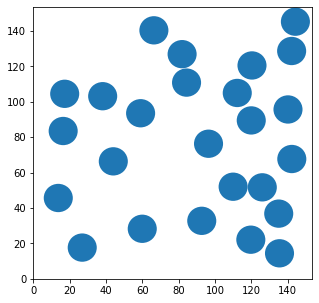

In [15]:
fig, ax = plt.subplots(figsize = (5,5))

Nc = 25; r = 8;
comp_center = models_phenom._distribute_circular_compartments(Nc, r, L)

for c in comp_center:
    circle = plt.Circle((c[0], c[1]), r)
    ax.add_patch(circle)
ax.set_xlim(0,L)
ax.set_ylim(0,L)

In [16]:
trajs, labels = models_phenom().confinement(N = N,
                                           T = T,
                                           L = L,
                                           trans = 0.1,
                                           alphas = np.array([[0.7]*3, [0.7]*3]), # we need three numbers because of pert distributio
                                           Ds = np.array([[D*10]*3, [D]*3]),
                                           comp_center = comp_center,
                                           r = r
                                           )

# Adding small localization noise
trajs += np.random.randn(T, N, 2)*sigma_noise

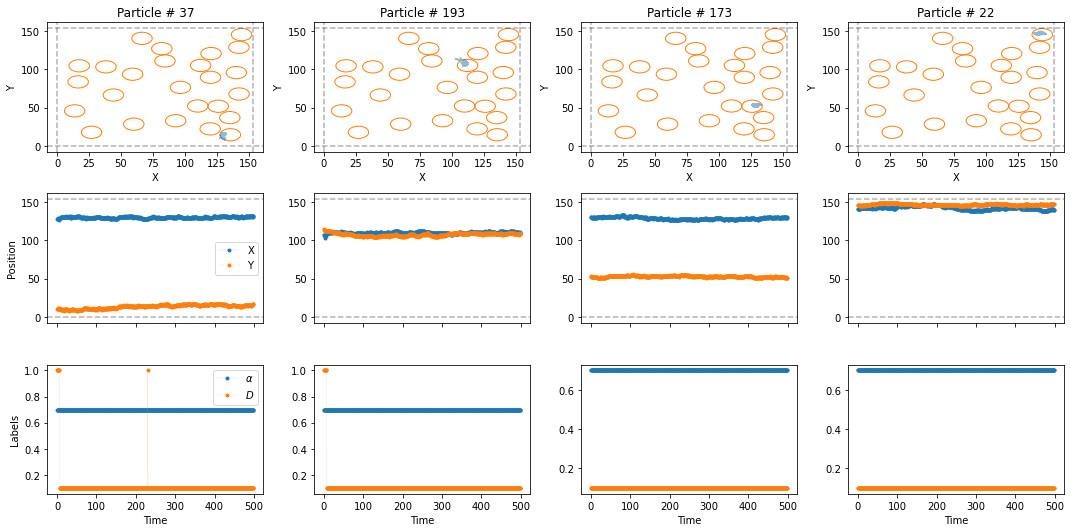

In [17]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

for ax in axs.transpose():
    part = np.random.randint(200)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.5)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    for c in comp_center:
        circle = plt.Circle((c[0], c[1]), r, facecolor = 'None', edgecolor = 'C1')
        ax[0].add_patch(circle)
    
    ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
    ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

In [18]:
t_df = trajs.transpose((1, 0, 2)).copy()
labels_df = labels.transpose(1, 0, 2)

xs = []
ys = []
als = []
ds = []
idxs = []

idx_t = 0
for traj, l_alpha, l_D in zip(tqdm(t_df), labels_df[:, :, 0], labels_df[:, :, 1]):
    
    # Check FOV and 
    idx_inside_segments = segs_inside_fov(traj, fov_max, fov_min, min_length)
    
    if idx_inside_segments is not None:
        
        for idx_in in idx_inside_segments:            
            seg_x = traj[idx_in[0]:idx_in[1], 0]
            seg_y = traj[idx_in[0]:idx_in[1], 1]
            seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
            seg_D = l_D[idx_in[0]:idx_in[1]]
            
            # filtering labels
            seg_alpha = label_filter(seg_alpha)
            seg_D = label_filter(seg_D)

            xs += seg_x.tolist()
            ys += seg_y.tolist()
            als += seg_alpha.tolist()
            ds += seg_D.tolist()
            idxs += (np.ones(len(seg_x))*idx_t).tolist()
            
            idx_t += 1            
            
tr_to_df = np.vstack((idxs,
                      xs,
                      ys)).transpose()

labs_to_df = np.vstack((idxs,
                        als,
                        ds)).transpose()

df_in3 = pd.DataFrame(tr_to_df)
df_out3 = pd.DataFrame(labs_to_df)
    
df_in3.columns = ['idx', 'x', 'y']
df_out3.columns = ['idx', 'alpha', 'D']

  0%|          | 0/5000 [00:00<?, ?it/s]

d:\repos\andi_datasets_dev\andi_datasets\utils_trajectories.py:214: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


In [19]:
df_in3.to_csv('../exports/condition_3.csv', index = False)
df_out3.to_csv('../exports/labels_condition_3.csv', index = False)

### Condition 4 $\rightarrow$ Trapping

- $\alpha = 0.8$
- $D =2*D$ (non-trapped diffusion)
- Trap density $= 0.8$.
- $P_b = 1$; $P_u=0.05$

In [20]:
alpha = 0.8; D_out_trap = 2*D
Pb = 1; Pu = 0.05
# Traps distributions
Nt = int(L*0.8); r = 1
traps_pos = np.random.rand(Nt, 2)*L 

trajs, labels = models_phenom().immobile_traps(N = 1000,
                                            T = T,                
                                            L = L,
                                            r = r,
                                            Pu = Pu, # Unbinding probability
                                            Pb = Pb, # Binding probability
                                            D = D_out_trap, # Diffusion coefficients of two states
                                            alpha = alpha, # Anomalous exponents for two states
                                            Nt = Nt,
                                            traps_pos = traps_pos
                                            )

trajs += np.random.randn(T, 1000, 2)*sigma_noise

  0%|          | 0/499 [00:00<?, ?it/s]

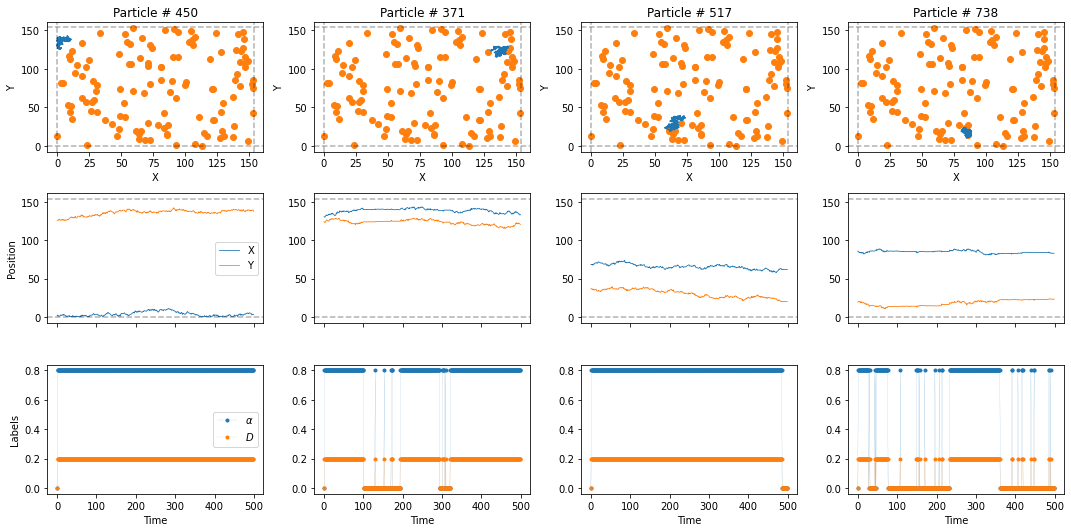

In [21]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)


for ax in axs.transpose():
    
    ax[0].scatter(traps_pos[:,0], traps_pos[:,1], c = 'C1')
    
    part = np.random.randint(1000)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[:, part, 0], trajs[:, part, 1])
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(trajs[:, part, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[:, part, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');

In [22]:
t_df = trajs.transpose((1, 0, 2)).copy()
labels_df = labels.transpose(1, 0, 2)

xs = []
ys = []
als = []
ds = []
idxs = []

idx_t = 0
for traj, l_alpha, l_D in zip(tqdm(t_df), labels_df[:, :, 0], labels_df[:, :, 1]):
    
    # Check FOV and 
    idx_inside_segments = segs_inside_fov(traj, fov_max, fov_min, min_length)
    
    if idx_inside_segments is not None:
        
        for idx_in in idx_inside_segments:            
            seg_x = traj[idx_in[0]:idx_in[1], 0]
            seg_y = traj[idx_in[0]:idx_in[1], 1]
            seg_alpha = l_alpha[idx_in[0]:idx_in[1]]
            seg_D = l_D[idx_in[0]:idx_in[1]]
            
            # filtering labels
            seg_alpha = label_filter(seg_alpha)
            seg_D = label_filter(seg_D)

            xs += seg_x.tolist()
            ys += seg_y.tolist()
            als += seg_alpha.tolist()
            ds += seg_D.tolist()
            idxs += (np.ones(len(seg_x))*idx_t).tolist()
            
            idx_t += 1            
            
tr_to_df = np.vstack((idxs,
                      xs,
                      ys)).transpose()

labs_to_df = np.vstack((idxs,
                        als,
                        ds)).transpose()

df_in4 = pd.DataFrame(tr_to_df)
df_out4 = pd.DataFrame(labs_to_df)
    
df_in4.columns = ['idx', 'x', 'y']
df_out4.columns = ['idx', 'alpha', 'D']

  0%|          | 0/1000 [00:00<?, ?it/s]

d:\repos\andi_datasets_dev\andi_datasets\utils_trajectories.py:214: RuntimeWarning: All-NaN slice encountered
  merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)


In [23]:
df_in4.to_csv('../exports/condition_4.csv', index = False)
df_out4.to_csv('../exports/labels_condition_4.csv', index = False)

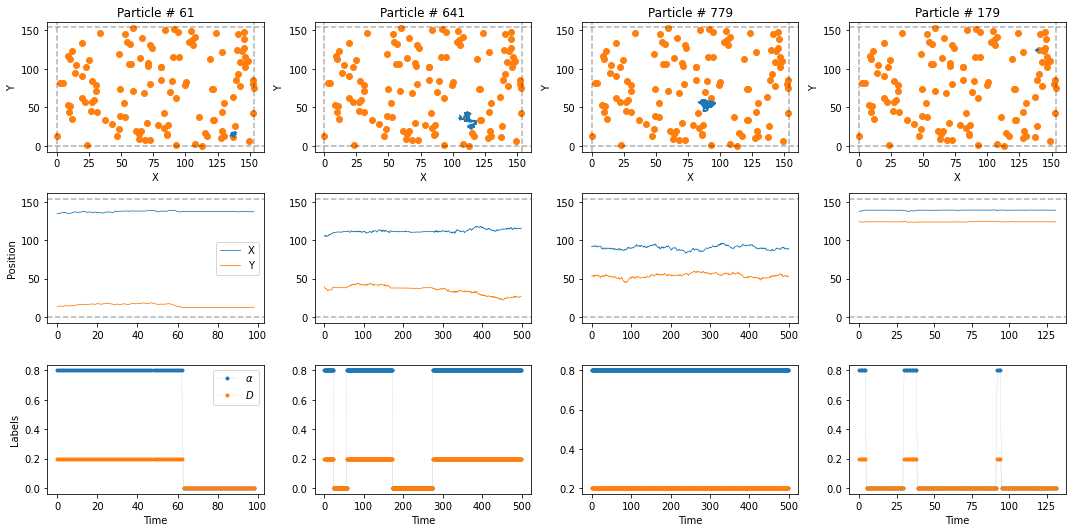

In [24]:
fig, axs = plt.subplots(3, 4, figsize = (15, 7.5), tight_layout = True)

idx_trajs = np.random.randint(0, 1000, axs.shape[1])

for ax, idx in zip(axs.transpose(), idx_trajs):
    
    x = df_in4.loc[df_in4.idx == idx].x.values
    y = df_in4.loc[df_in4.idx == idx].y.values
    la = df_out4.loc[df_out4.idx == idx].alpha.values
    ld = df_out4.loc[df_out4.idx == idx].D.values
    
    ax[0].scatter(traps_pos[:,0], traps_pos[:,1], c = 'C1')
    
    part = np.random.randint(1000)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(x, y)
    ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[1].plot(x, '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(y, '-', label = 'Y', ms = 3, lw = 0.8)
    ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
    ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
    
    ax[2].plot(la, 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
    ax[2].plot(ld, 'o-', label = r'$D$', ms = 3, lw = 0.1)


plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')

axs[1, 0].legend()
plt.setp(axs[1, 0], ylabel = 'Position')
# plt.setp(axs[1, :], xticklabels = '')

axs[2, 0].legend()
plt.setp(axs[2, 0], ylabel = 'Labels')
plt.setp(axs[2, :], xlabel = 'Time');